In [1]:
import numpy as np
import struct
import pickle as pkl
import cupy as cp
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
cp.__version__

'10.6.0'

In [2]:
mnist_dir = '../input/original-mnist/mnist'

def load_mnist_data(mnist_dir):
    def load_images(filename):
        with open(filename, 'rb') as f:
            _, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            data = cp.fromfile(f, dtype=cp.uint8).reshape(num_images, rows * cols)
        return data

    def load_labels(filename):
        with open(filename, 'rb') as f:
            _, num_labels = struct.unpack('>II', f.read(8))
            labels = cp.fromfile(f, dtype=cp.uint8)
        return labels

    train_images_path = os.path.join(mnist_dir, 'train-images.idx3-ubyte')
    train_labels_path = os.path.join(mnist_dir, 'train-labels.idx1-ubyte')
    test_images_path = os.path.join(mnist_dir, 't10k-images.idx3-ubyte')
    test_labels_path = os.path.join(mnist_dir, 't10k-labels.idx1-ubyte')

    train_images = load_images(train_images_path)
    train_labels = load_labels(train_labels_path)
    test_images = load_images(test_images_path)
    test_labels = load_labels(test_labels_path)

    return [cp.asarray(train_images/255), cp.asarray(train_labels), cp.asarray(test_images/255), cp.asarray(test_labels)]


def one_hot(labels, num_classes):
    one_hot_labels = cp.zeros((len(labels), num_classes))
    one_hot_labels[cp.arange(len(labels)), labels] = 1
    return one_hot_labels

def relu(Z):
    return cp.maximum(0, Z)

def softmax(Z):
    expZ = cp.exp(Z - cp.max(Z, axis=1, keepdims=True))
    return expZ / expZ.sum(axis=1, keepdims=True)

def initialize_parameters(icput_size, hidden_size, output_size, seed):
    cp.random.seed(seed)
    W1 = cp.random.randn(hidden_size, icput_size) * 0.01
    b1 = cp.zeros((1, hidden_size))
    W2 = cp.random.randn(output_size, hidden_size) * 0.01
    b2 = cp.zeros((1, output_size))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


def forward_propagation(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]

    O1 = cp.dot(X, W1.T) + b1
    H = relu(O1)
    O2 = cp.dot(H, W2.T) + b2
    output = softmax(O2)

    cache = {"O1": O1, "H": H, "O2": O2, "output": output}
    return output, cache

def compute_loss(Y, output, parameters, lambd):
    '''Y:label, one-hot matrix, for test 10k data Y.shape=(10000,10) '''
    m = Y.shape[0]
    W1, W2 = parameters["W1"], parameters["W2"]
    cross_entropy = -cp.sum(Y * cp.log(output + 1e-8)) / m
    L2_regularization_cost = (lambd / (2 * m)) * (cp.sum(cp.square(W1)) + cp.sum(cp.square(W2)))
    loss = cross_entropy + L2_regularization_cost
    return loss


def backward_propagation(X, Y, cache, parameters, lambd):
    m = X.shape[0]
    W1, W2 = parameters["W1"], parameters["W2"]
    H, output = cache["H"], cache["output"]

    dO2 = output - Y
    dW2 = (1 / m) * cp.dot(dO2.T, H) + (lambd / m) * W2
    db2 = (1 / m) * cp.sum(dO2, axis=0, keepdims=True)
    dH = cp.dot(dO2, W2)
    dO1 = cp.where(H > 0, dH, 0)
    dW1 = (1 / m) * cp.dot(dO1.T, X) + (lambd / m) * W1
    db1 = (1 / m) * cp.sum(dO1, axis=0, keepdims=True)

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads


class SGD:
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self, grads):
        for key in self.parameters:
            self.parameters[key] -= self.learning_rate * grads["d" + key]

    def update_learning_rate(self, new_learning_rate):
        self.learning_rate = new_learning_rate


def learning_rate_decay(learning_rate, decay_rate, epoch, decay_step):
    return learning_rate * (decay_rate ** (epoch / decay_step))


def compute_accuracy(one_hot_labels, one_hot_predictions):
    true_labels = cp.argmax(one_hot_labels, axis=1)
    predicted_labels = cp.argmax(one_hot_predictions, axis=1)
    correct_predictions = cp.sum(true_labels == predicted_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy


def save_model(model, path):
    with open(path, 'wb') as f:
        pkl.dump(model, f)


def train(data, lr, hidden_size, l2_penalty, seed=42,
          batch=4096, epochs=600, decay_step=300, decay_rate=0.95, num_classes=10):
    train_images, train_labels, test_images, test_labels = data[0], data[1], data[2], data[3]
    n = train_images.shape[0]
    np.random.seed(seed)
    valid_idx = np.random.choice(range(n),size=n//5,replace=False)
    train_idx = np.setdiff1d(np.arange(n),valid_idx)
    valid_images = train_images[valid_idx,:]
    valid_labels = train_labels[valid_idx]
    train_images = train_images[train_idx,:]
    train_labels = train_labels[train_idx]
    n_tr = train_images.shape[0]
    tr_loader_nums = n_tr//batch if batch * (n_tr//batch) == n_tr else n_tr//batch+1


    tr_loss_l = []
    va_loss_l = []
    te_loss_l = []
    te_acc_l = []

    params = initialize_parameters(784, hidden_size, 10, seed)
    optimizer = SGD(params, lr)

    for epoch in tqdm(range(epochs),position=0):
        tr_loss_sum = 0
        for i in range(tr_loader_nums):
            x, y = train_images[i*batch:(i+1)*batch], one_hot(train_labels[i*batch:(i+1)*batch],num_classes)
            y_pred, cache = forward_propagation(x, params)
            loss = compute_loss(y, y_pred, params, l2_penalty)
            tr_loss_sum += loss * y.shape[0]
            grads = backward_propagation(x, y, cache, params, l2_penalty)
            optimizer.step(grads)

        tr_loss_l.append(tr_loss_sum.get()/n)

        x, y = valid_images, one_hot(valid_labels, num_classes)
        y_pred, cache = forward_propagation(x, params)
        loss = compute_loss(y, y_pred, params, l2_penalty)
        va_loss_l.append(loss.get())

        x, y = test_images, one_hot(test_labels, num_classes)
        y_pred, cache = forward_propagation(x, params)
        loss = compute_loss(y, y_pred, params, l2_penalty)
        te_loss_l.append(loss.get())

        acc = compute_accuracy(y, y_pred)
        te_acc_l.append(acc.get())
        learning_rate = learning_rate_decay(lr, decay_rate, epoch, decay_step)
        optimizer.update_learning_rate(learning_rate)
    return tr_loss_l, va_loss_l, te_loss_l, te_acc_l, params


def param_search(lr_l, hidden_size_l, l2_penalty_l):
    data = load_mnist_data(mnist_dir)
    res = {}
    for lr in tqdm(lr_l):
        for hidden_size in hidden_size_l:
            for l2_penalty in l2_penalty_l:
                _, va, _, _, params = train(data,lr,hidden_size,l2_penalty)
                path = 'lr:'+str(lr)+'  h_s:'+str(hidden_size)+'  l2_penalty:'+str(l2_penalty)
                res[path] = va[-1]
                save_model(params, path+'.pkl')
    return res

In [3]:
'''在验证集上参数搜索'''
res = param_search([0.7,0.5,0.1],[100,200],[1,20])
print(f'best_param: {min(res,key=res.get)},last epoch valid set loss: {res[min(res,key=res.get)]}')


'''载入模型并在测试集评价'''
with open('/kaggle/working/lr:0.7  h_s:200  l2_penalty:1.pkl', 'rb') as f:
    model = pkl.load(f)
data = load_mnist_data(mnist_dir)
test_images,test_labels=data[2],data[3]
y = one_hot(test_labels,10)
pred_y,_ = forward_propagation(test_images,model)
print(f'测试集分类准确率： {compute_accuracy(y,pred_y)}')


100%|██████████| 3/3 [02:35<00:00, 51.67s/it]


best_param: lr:0.7  h_s:200  l2_penalty:1,last epoch valid set loss: 0.08214767499974564
测试集分类准确率： 0.9802


100%|██████████| 600/600 [00:13<00:00, 45.26it/s]


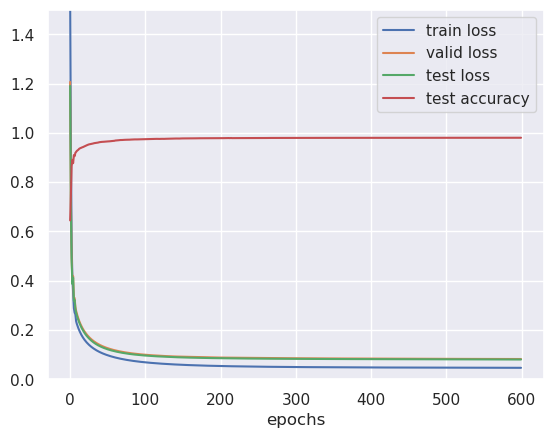

In [4]:
'''可视化'''
sns.set()
tr,va,te,te_a,params = train(data, lr=0.7, hidden_size=200, l2_penalty=1)
fig,ax1 = plt.subplots()
epochs=600
ax1.plot(range(epochs),tr,label='train loss')
ax1.plot(range(epochs),va,label='valid loss')
ax1.plot(range(epochs),te,label='test loss')
ax1.plot(range(epochs),te_a,label='test accuracy')
ax1.legend(loc= 'upper right')
ax1.set_xlabel('epochs')    #设置x轴标题
# ax1.set_ylabel('loss')  
ax1.set_ylim([0,1.5])
plt.savefig('loss.png')
plt.show()

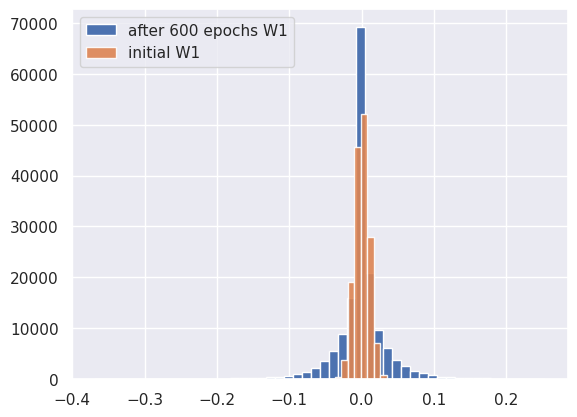

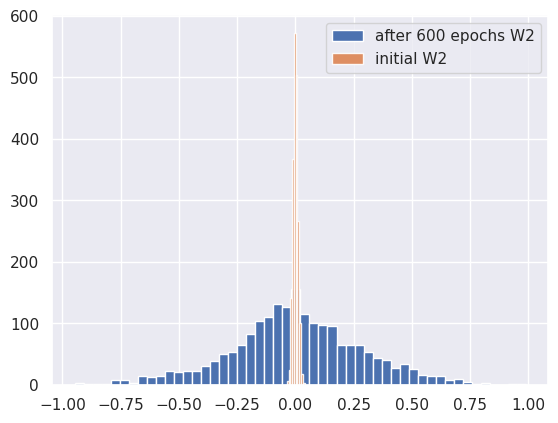

In [5]:
cp.random.seed(42)
init_W1 = cp.random.randn(784, 200).get().reshape(-1,1) * 0.01
init_W2 = cp.random.randn(200, 10).get().reshape(-1,1) * 0.01
plt.hist(model['W1'].get().reshape(-1,1),bins=50,label='after 600 epochs W1')
plt.hist(init_W1,label='initial W1',alpha=0.9)
plt.legend()
plt.savefig('W1.png')
plt.figure()
plt.hist(model['W2'].get().reshape(-1,1),bins=50,label='after 600 epochs W2')
cp.random.seed(42)
plt.hist(init_W2,label='initial W2',alpha=0.9)
plt.legend()
plt.savefig('W2.png')

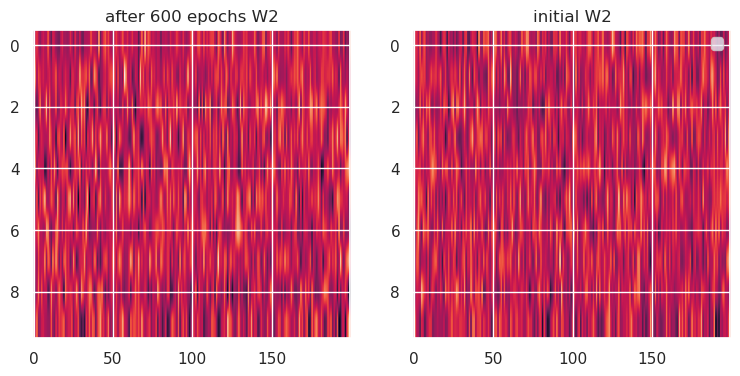

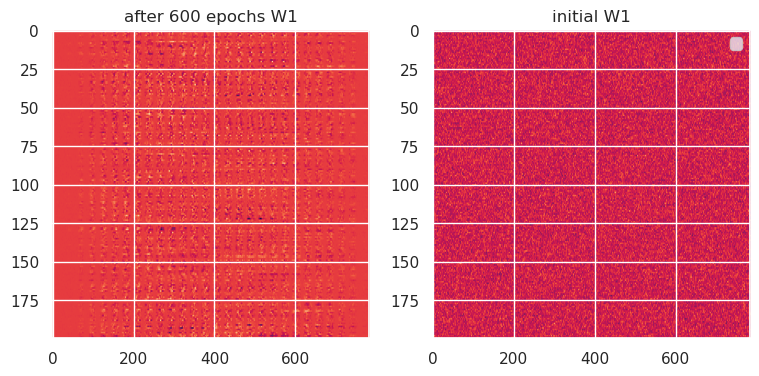

In [6]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
import matplotlib.colors as colors
plt.imshow(model['W2'].get(),aspect='auto')
plt.title('after 600 epochs W2')
plt.subplot(1,2,2)
plt.imshow(init_W2.reshape(10,-1),aspect='auto')
plt.title('initial W2')
plt.legend()
plt.savefig('W2_HEAT.png')
plt.show()

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
import matplotlib.colors as colors
plt.imshow(model['W1'].get(),aspect='auto')
plt.title('after 600 epochs W1')
plt.subplot(1,2,2)
plt.imshow(init_W1.reshape(200,-1),aspect='auto')
plt.title('initial W1')
plt.legend()
plt.savefig('W1_HEAT.png')
plt.show()
